In [1]:
import os
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import tifffile
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.neighbors import NearestNeighbors
from autobl.steering import configs, measurement
from autobl import image_proc
from tqdm.notebook import tqdm, trange


In [2]:
# Load the image and initialize the probe
image = tifffile.imread(os.path.join("tests", "data", "xrf", "ground_609_full.tiff"))  # Load the XRF image data
probe = np.ones((4, 4))  # Initialize a 4x4 probe with all ones (a simple uniform probe)

# Set up the experiment parameters              Yu_Q1: what is the psize_nm size mean?
sample_params = configs.SpatialSampleParams(image=image, psize_nm=1)  # Define spatial sample parameters, including the image and pixel size

setup_params = configs.FlyScanExperimentSetupParams(
    psize_nm=1.0,  # Pixel size in nanometers
    scan_speed_nm_sec=1.0,  # Scanning speed in nanometers per second
    exposure_sec=0.2,  # Exposure time in seconds
    deadtime_sec=0.05,  # Dead time between scans in seconds
    probe=probe,  # Use the initialized probe for the experiment
)

measurement_configs = configs.FlyScanSimulationConfig(
    sample_params=sample_params,  # Use the defined spatial sample parameters
    setup_params=setup_params,  # Use the defined experimental setup parameters
    step_size_for_integration_nm=0.02,  # Step size for integration in nanometers
)

# Initialize the measurement interface for the FlyScan simulation
measurement_interface = measurement.FlyScanSingleValueSimulationMeasurement(measurement_configs)

# Initialize the reconstructor with Inverse Distance Weighting (IDW) method, using PyTorch as the backend
reconstructor = image_proc.Reconstructor("idw", backend="torch")

In [3]:
# Define the distortion function
def calculate_distortion(image, reconstruction):
    return 0.5 * (image - reconstruction) ** 2

In [4]:
# whole image grid points
y_dense = torch.arange(0.0, image.shape[0], 1)
x_dense = torch.arange(0.0, image.shape[1], 1)
meshgrids_dense = torch.meshgrid(y_dense, x_dense, indexing='ij')
xi = torch.stack(meshgrids_dense, dim=-1).reshape(-1, len(meshgrids_dense))

# initila scan 
y_current = torch.arange(10, image.shape[0] - 10, 1)
x_current = torch.arange(0, image.shape[1], 90) # 30 -> 60 -> 90
meshgrids_current = torch.meshgrid(y_current, x_current, indexing='ij')
points_current = torch.stack(meshgrids_current, axis=-1).reshape(-1, len(meshgrids_current))
initial_points = len(points_current)
# # Get the values at the current points from the measurement interface
values_current = torch.tensor(measurement_interface.measure(points_current))

test_positions = measurement_interface.measured_positions 
test_positions = torch.tensor(test_positions)

# Retrieve the probe image for comparison
probe_image = measurement_interface.probe_image

# Set n_neighbors to be the minimum of 30 or the number of available points
n_neighbors = min(30, len(points_current))
# Perform the initial reconstruction using the IDW method (1st reconstruction)
recon_current = reconstructor.reconstruct_idw_torch(test_positions, values_current, xi=xi, n_neighbors=n_neighbors, power=2) #Yu_Q:how to choose
initial_recon = recon_current.detach().numpy().reshape(meshgrids_dense[0].shape)

# Calculate the distortion between the reconstruction and the probe image
distortion_before = calculate_distortion(initial_recon, probe_image)

# The following variables are now available for further processing or plotting:
# points_current, values_current, probe_image, xi, meshgrids_dense, recon_current, distortion_before

In [5]:
# Compute the acquisition function for uncertainty estimation
def compute_acquisition_function(points, values, xi, nn_inds, reconstructor, sigma=1.0, length=4.0):
    # Perform IDW reconstruction to get the predicted values
    recon_current = reconstructor.reconstruct_idw_torch(points, values, xi=xi, nn_inds=nn_inds, power=2)
    # Calculate the gradient of the reconstruction
    gradient = reconstructor.reconstruct_idw_grad_torch(points, values, xi=xi, nn_inds=nn_inds, power=2)
    gradient_norm = torch.linalg.norm(gradient, axis=0)
    # Estimate uncertainty using the RBF-like uncertainty model
    uncertainty = rbf_uncertainty(points, xi, sigma=sigma, nn_inds=nn_inds, length=length)
    # Combine uncertainty with the gradient norm to form the acquisition function
    acquisition = uncertainty * gradient_norm
    return acquisition 

def rbf_uncertainty(points, xi, sigma=1.0, nn_inds=None, length=4.0):
    if nn_inds is None:
        # Calculate distances if not provided
        square_dists = torch.sum((xi[:, None, :] - points[None, :, :]) ** 2, dim=-1)
    else:
        # Use provided nearest neighbors indices to compute distances
        square_dists = torch.sum((xi[:, None, :] - points[nn_inds]) ** 2, dim=-1)
    # Normalize distances by length scale
    square_dists /= length ** 2
    # Compute softmax weights based on distances
    softmax_weights = torch.softmax(-square_dists, dim=-1)
    # Compute weighted sum of distances to get uncertainty
    uncertainty = sigma**2 * (1 - torch.exp(torch.sum(-softmax_weights * square_dists, axis=-1))) 
    return uncertainty #relation bt loss and distortion
    

In [6]:
# # Perform optimization to reduce acquisition
def optimize_scan_points(points_current, values_current, xi, reconstructor):
    # Generate random scan points for optimization
    points_scan = np.stack((
        np.random.uniform(2, probe_image.shape[0] - 2, size=(2000,)),
        np.random.uniform(2, probe_image.shape[1] - 2, size=(2000,))
    ), axis=-1)
    points_scan = torch.tensor(points_scan, requires_grad=True)

    optimizer = optim.Adam([points_scan], lr=0.01)

    for i in trange(50):
        # Perform pseudo-reconstruction
        pseudo_values_scan = reconstructor.reconstruct_idw_torch(
            points_current, values_current, xi=points_scan, n_neighbors=30, power=2)
        
        # Combine current and pseudo scan points
        points_combined = torch.cat((points_current, points_scan))
        values_combined = torch.cat((values_current, pseudo_values_scan))

        # Compute nearest neighbors for combined points
        knn_engine = NearestNeighbors(n_neighbors=30)
        knn_engine.fit(points_combined.detach().numpy())
        nn_inds = knn_engine.kneighbors(xi, return_distance=False)

        # Compute acquisition function for uncertainty estimation
        acquisition = -compute_acquisition_function(points_combined, values_combined, xi, nn_inds, reconstructor)

        # Backpropagate the uncertainty (used as a loss function here)
        avg_loss = torch.mean(acquisition) # scalar
        avg_loss.backward()  # Uncertainty is minimized
        optimizer.step()

        print(f"Iteration {i}, avg_loss: {avg_loss.item()}", end='\r')
        

    # Convert PyTorch tensors to NumPy arrays
    points_scan_np = points_scan.detach().numpy()
    points_current_np = points_current.detach().numpy()

    # Remove points_current_np from points_scan_np
    # This ensures that any points in points_current_np are excluded from points_scan_np
    filtered_points_scan_np = np.array([p for p in points_scan_np if p.tolist() not in points_current_np.tolist()])

    # Proceed with your operations using `filtered_points_scan_np`
    print(f"Original points_scan: {len(points_scan_np)}")
    print(f"Filtered points_scan (after removing points_current): {len(filtered_points_scan_np)}")


    return filtered_points_scan_np, nn_inds


In [7]:
# Run the process
optimized_scan_points, nn_inds = optimize_scan_points(points_current, values_current, xi, reconstructor)
# len(optimized_scan_points)
print(optimized_scan_points)

  0%|          | 0/50 [00:00<?, ?it/s]

Original points_scan: 2000.0069951451294176286
Filtered points_scan (after removing points_current): 2000
[[ 75.05502105  21.48257466]
 [ 54.94341771 169.39044947]
 [ 18.24972285 390.68891167]
 ...
 [  6.64939715 213.7131505 ]
 [ 77.0969498   70.88213851]
 [ 33.14102006 264.01625875]]


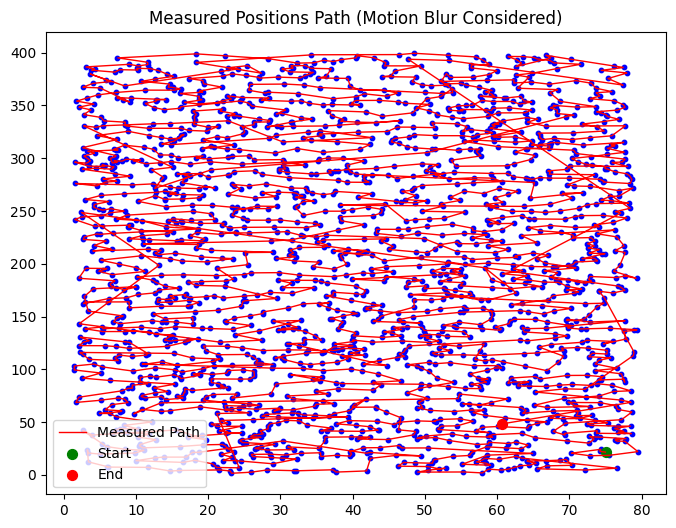

Total unique measured points along the path: 30824


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

# Helper function to remove consecutive duplicate points
def remove_consecutive_duplicates(points):
    """Remove consecutive duplicate points from a list of points."""
    unique_points = [points[0]]
    for i in range(1, len(points)):
        if not np.allclose(points[i], points[i - 1]):
            unique_points.append(points[i])
    return np.array(unique_points)

# Function to calculate total distance of a path
def total_distance(path, dist_matrix):
    dist = 0
    for i in range(len(path) - 1):
        dist += dist_matrix[path[i], path[i + 1]]
    return dist

# Function to find nearest neighbor path
def nearest_neighbor_tsp(start_point, dist_matrix):
    num_points = len(dist_matrix)
    unvisited = list(range(num_points))
    path = [start_point]
    unvisited.remove(start_point)

    current_point = start_point
    while unvisited:
        # Find nearest unvisited neighbor
        next_point = min(unvisited, key=lambda i: dist_matrix[current_point, i])
        path.append(next_point)
        unvisited.remove(next_point)
        current_point = next_point

    return path

measurement_configs = configs.FlyScanSimulationConfig(
    sample_params=sample_params,  # Use the defined spatial sample parameters
    setup_params=setup_params,  # Use the defined experimental setup parameters
    step_size_for_integration_nm=0.02,  # Step size for integration in nanometers
)
# Set up the simulator
simulator = measurement.FlyScanSingleValueSimulationMeasurement(measurement_configs)

# Calculate the distance matrix for the optimized scan points
dist_matrix = distance_matrix(optimized_scan_points, optimized_scan_points)

# Define start point and get the TSP path using nearest neighbor heuristic
start_point = 0
tsp_path = nearest_neighbor_tsp(start_point, dist_matrix)

# Reorder the optimized scan points according to the TSP path
ordered_scan_points = [optimized_scan_points[i] for i in tsp_path]

# Use simulator's measure method to simulate the scan with motion blur
# ordered_scan_points are the list of vertices (waypoints)
measured_values = simulator.measure(ordered_scan_points)  # This returns I_hats
measured_positions = simulator.measured_positions  # This returns r_hats

# Remove consecutive duplicate measured positions (if any)
#measured_positions = remove_consecutive_duplicates(measured_positions)

# Convert the measured positions into a NumPy array for plotting
measured_positions = np.array(measured_positions)
all_path_points = measured_positions
# Plot the measured path
plt.figure(figsize=(8, 6))

# Plot the measured TSP path (with motion blur considered)
plt.plot(measured_positions[:, 0], measured_positions[:, 1], 'r-', lw=1, label='Measured Path')

# Plot each point from the original optimized scan points
for i, (x, y) in enumerate(optimized_scan_points):
    plt.scatter(x, y, color='blue', s=10)

# Add start and end labels
plt.scatter(optimized_scan_points[start_point][0], optimized_scan_points[start_point][1], color='green', s=50, label='Start')
plt.scatter(optimized_scan_points[tsp_path[-1]][0], optimized_scan_points[tsp_path[-1]][1], color='red', s=50, label='End')

# Add title and legend
plt.title('Measured Positions Path (Motion Blur Considered)')
plt.legend()
plt.show()

# Print the number of unique points along the path (measured positions)
total_points_in_path = len(measured_positions)
print(f"Total unique measured points along the path: {total_points_in_path}")


In [9]:
#optimal_scan_points = ordered_scan_points # method 2
#optimal_scan_points = complete_path_np # method 3
import torch

# Use measured positions and values for reconstruction
optimal_scan_points = measured_positions  # Use measured positions (r_hats)
optimal_scan_values = measured_values  # Use measured values (I_hats)

# Convert measured positions back to a tensor
optimal_scan_points_tensor = torch.tensor(optimal_scan_points, dtype=torch.float32)

# Combine the initial points and the measured scan points into one final set of points
points_final = torch.cat((test_positions, optimal_scan_points_tensor))

# Convert measured values to a tensor
optimal_scan_values_tensor = torch.tensor(optimal_scan_values, dtype=torch.float32)

# Combine the initial values and the measured values into one final set of values
values_final = torch.cat((values_current, optimal_scan_values_tensor))

# Perform the final reconstruction using the combined points and values
recon_final = reconstructor.reconstruct_idw_torch(points_final, values_final, xi=xi, n_neighbors=30, power=2)

# Convert the reconstruction to a NumPy array for visualization and PSNR calculation
recon_final_np = recon_final.detach().numpy().reshape(meshgrids_dense[0].shape)

# Calculate the distortion between the reconstructed image and the true probe image
distortion_final = calculate_distortion(recon_final_np, probe_image)

# Compute the PSNR between the final reconstruction and the true probe image
psnr_value = psnr(probe_image, recon_final_np, data_range=probe_image.max() - probe_image.min())
print(f"PSNR between the final reconstruction and the true image: {psnr_value} dB")

psnr_value = psnr(probe_image, initial_recon, data_range=probe_image.max() - probe_image.min())
print(f"PSNR between the initial reconstruction and the true image: {psnr_value} dB")

PSNR between the final reconstruction and the true image: 28.54231538683689 dB
PSNR between the initial reconstruction and the true image: 22.25504627250269 dB


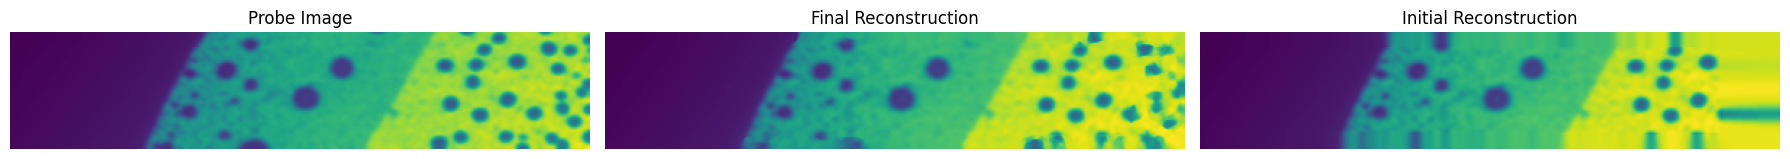

In [10]:
# Create a figure with 3 subplots in one row
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns, adjusted size

# Show the original probe image for comparison
axs[0].imshow(probe_image)
axs[0].set_title("Probe Image")
axs[0].axis('off')

# Visualize the final reconstruction
axs[1].imshow(recon_final_np)
axs[1].set_title("Final Reconstruction")
axs[1].axis('off')


# Visualize the initial reconstruction
axs[2].imshow(initial_recon)
axs[2].set_title("Initial Reconstruction")
axs[2].axis('off')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure with all three plots in one row
plt.show()

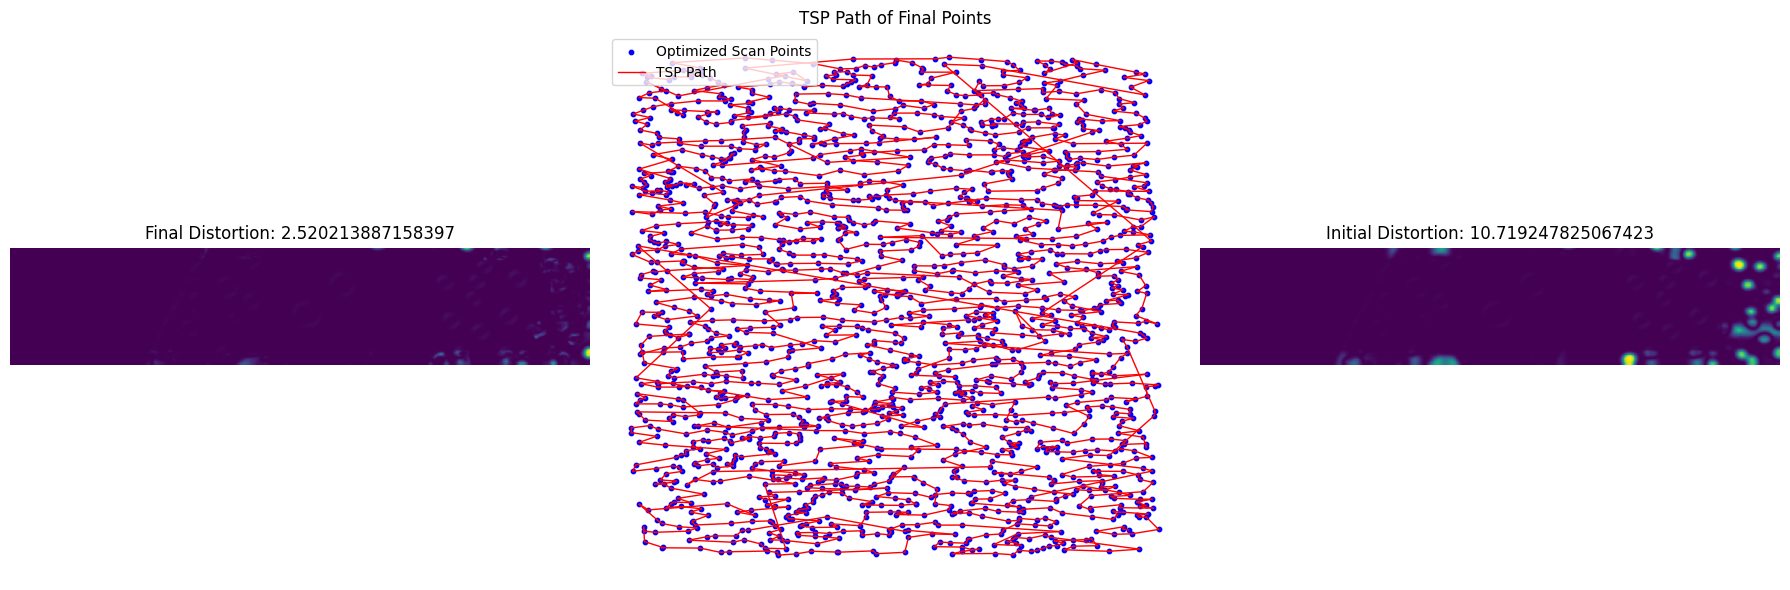

In [11]:
# Create a figure with 3 subplots in one row
points_final_np = points_final.detach().numpy()
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns, adjusted size

# Calculate and visualize the final distortion
axs[0].imshow(distortion_final)
axs[0].set_title(f"Final Distortion: {np.sum(distortion_final)}")
axs[0].axis('off')


# Plot 2: TSP Path of Final Points (Just the TSP Path connecting optimized points)
# Plot the optimized scan points
for i, (x, y) in enumerate(optimized_scan_points):
    axs[1].scatter(x, y, color='blue', s=10, label='Optimized Scan Points' if i == 0 else "")

# Plot the TSP path connecting the optimized scan points
for i in range(len(tsp_path) - 1):
    x_vals = [optimized_scan_points[tsp_path[i]][0], optimized_scan_points[tsp_path[i+1]][0]]
    y_vals = [optimized_scan_points[tsp_path[i]][1], optimized_scan_points[tsp_path[i+1]][1]]
    axs[1].plot(x_vals, y_vals, 'r-', lw=1, label='TSP Path' if i == 0 else "")

# Add title and legend to the second plot
axs[1].set_title("TSP Path of Final Points")
axs[1].legend()
axs[1].axis('off')


# Visualize the initial distortion
axs[2].imshow(distortion_before)
axs[2].set_title(f"Initial Distortion: {np.sum(distortion_before)}")
axs[2].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure with all three plots in one row
plt.show()

In [17]:
# Image dimensions
height, width = image.shape  # Assuming `image` is the 2D array of the image

# Total number of possible points in continuous space with 0.05 spacing
min_dist = 1
total_possible_points = (height * width) / (min_dist)

# Total number of filtered points from the optimal scan points and initial points
filtered_total_optimal_points = len(all_path_points)
filtered_total_initial_points = len(points_current)*10

# Calculate percentage of optimal points relative to the total possible continuous points
optimal_percentage = (2000 / total_possible_points) * 100
print(f"The filtered scan points represent {optimal_percentage:.2f}% of the total possible continuous points.")

# Calculate percentage of initial points relative to the total possible continuous points
initial_percentage = (filtered_total_initial_points / total_possible_points) * 100
print(f"The filtered initial points represent {initial_percentage:.2f}% of the total possible continuous points.")

# Calculate combined percentage of both initial and optimal points relative to the total possible continuous points
combined_points = filtered_total_optimal_points + filtered_total_initial_points
combined_percentage = (combined_points / total_possible_points) * 100
print(f"The combined filtered initial and optimal points represent {combined_percentage:.2f}% of the total possible continuous points.")



The filtered scan points represent 6.16% of the total possible continuous points.
The filtered initial points represent 9.39% of the total possible continuous points.
The combined filtered initial and optimal points represent 409.37% of the total possible continuous points.


32481
32481


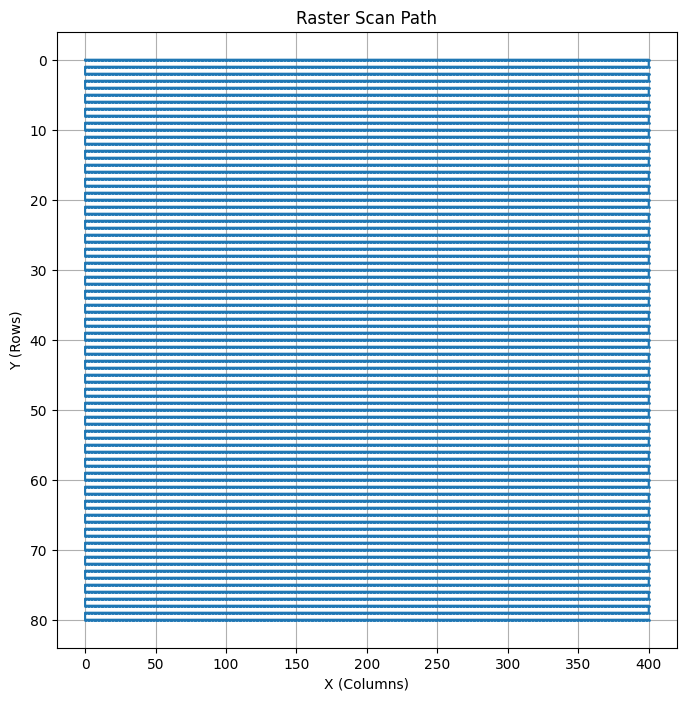

In [13]:
# Create an densely_points of FlyScanPathGenerator
densely_points = measurement.FlyScanPathGenerator(shape=[image.shape[0], image.shape[1]])

# Define the top-left and bottom-right positions
pos_top_left = [0, 0]  # Top left corner
pos_bottom_right = [image.shape[0] - 1, image.shape[1] - 1]  # Bottom right corner

# Generate a dense raster scan path (1 pixel spacing)
raster_scan_path = densely_points.generate_all_scan_path(pos_top_left, pos_bottom_right)

# Print the generated path length
print(len(raster_scan_path))  # Should now approach the total number of pixels

# Print the total number of pixels
print(image.shape[0] * image.shape[1])

# Plot the generated raster scan path
def plot_raster_scan_path(path):
    """
    Function to plot the raster scan path.
    :param path: np.ndarray. Generated raster scan path.
    """
    plt.figure(figsize=(8, 8))
    plt.plot(path[:, 1], path[:, 0], marker="o", markersize=1, linestyle='-')
    plt.gca().invert_yaxis()  # Optional: Invert y-axis for better visualization
    plt.title("Raster Scan Path")
    plt.xlabel("X (Columns)")
    plt.ylabel("Y (Rows)")
    plt.grid(True)
    plt.show()

# Call the plot function
plot_raster_scan_path(raster_scan_path)

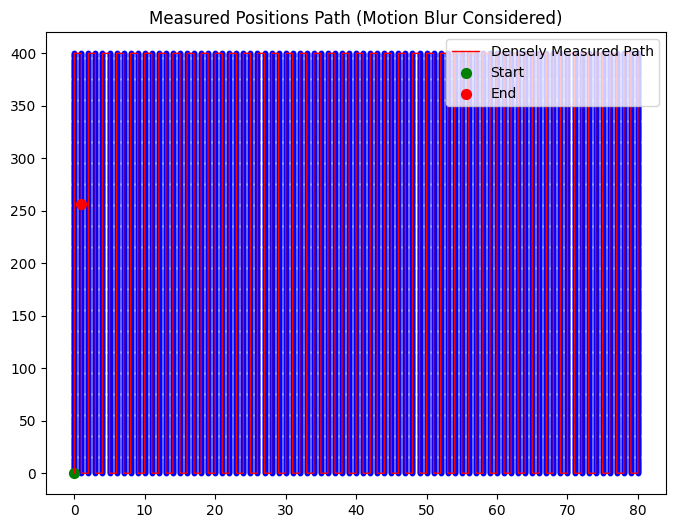

Total unique measured points along the path: 129919


In [14]:
# Use simulator's measure method to simulate the scan with motion blur
# ordered_scan_points are the list of vertices (waypoints)
densely_measured_values = simulator.measure(raster_scan_path)  # This returns I_hats
densely_measured_positions = simulator.measured_positions  # This returns r_hats

# Convert the measured positions into a NumPy array for plotting
densely_measured_positions = np.array(densely_measured_positions)
all_path_points = densely_measured_positions
# Plot the measured path
plt.figure(figsize=(8, 6))

# Plot the measured TSP path (with motion blur considered)
plt.plot(densely_measured_positions[:, 0], densely_measured_positions[:, 1], 'r-', lw=1, label='Densely Measured Path')

# Plot each point from the original optimized scan points
for i, (x, y) in enumerate(raster_scan_path):
    plt.scatter(x, y, color='blue', s=10)

# Add start and end labels
plt.scatter(raster_scan_path[start_point][0], raster_scan_path[start_point][1], color='green', s=50, label='Start')
plt.scatter(raster_scan_path[tsp_path[-1]][0], raster_scan_path[tsp_path[-1]][1], color='red', s=50, label='End')

# Add title and legend
plt.title('Measured Positions Path (Motion Blur Considered)')
plt.legend()
plt.show()

# Print the number of unique points along the path (measured positions)
total_points_in_path = len(densely_measured_positions)
print(f"Total unique measured points along the path: {total_points_in_path}")

In [15]:
import torch

# Use measured positions and values for reconstruction
optimal_scan_points = densely_measured_positions  # Use measured positions (r_hats)
optimal_scan_values = densely_measured_values  # Use measured values (I_hats)

# Convert measured positions back to a tensor
optimal_scan_points_tensor = torch.tensor(optimal_scan_points, dtype=torch.float32)

# Combine the initial points and the measured scan points into one final set of points
points_final = optimal_scan_points_tensor

# Convert measured values to a tensor
optimal_scan_values_tensor = torch.tensor(optimal_scan_values, dtype=torch.float32)

# Combine the initial values and the measured values into one final set of values
values_final = optimal_scan_values_tensor

# Perform the final reconstruction using the combined points and values
recon_final = reconstructor.reconstruct_idw_torch(points_final, values_final, xi=xi, n_neighbors=30, power=2)

# Convert the reconstruction to a NumPy array for visualization and PSNR calculation
recon_final_np = recon_final.detach().numpy().reshape(meshgrids_dense[0].shape)

# Calculate the distortion between the reconstructed image and the true probe image
distortion_final = calculate_distortion(recon_final_np, probe_image)

# Compute the PSNR between the final reconstruction and the true probe image
psnr_value = psnr(probe_image, recon_final_np, data_range=probe_image.max() - probe_image.min())
print(f"PSNR between the final reconstruction and the true image: {psnr_value} dB")

PSNR between the final reconstruction and the true image: 34.04311818830268 dB


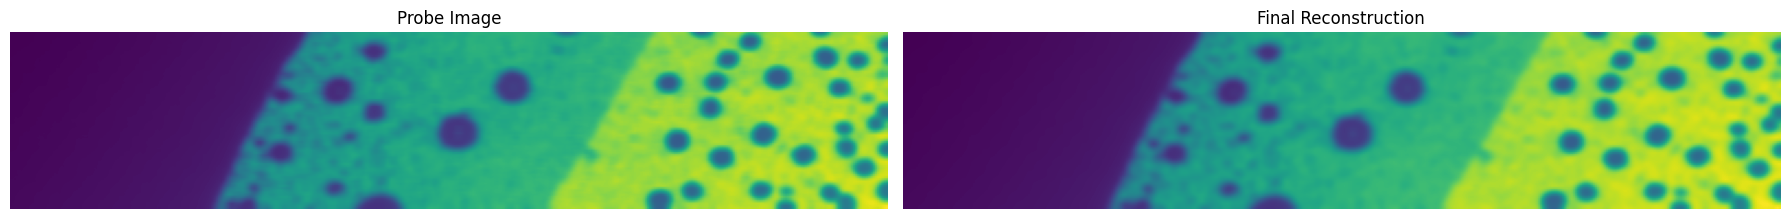

In [16]:
# Create a figure with 3 subplots in one row
fig, axs = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 3 columns, adjusted size

# Show the original probe image for comparison
axs[0].imshow(probe_image)
axs[0].set_title("Probe Image")
axs[0].axis('off')

# Visualize the final reconstruction
axs[1].imshow(recon_final_np)
axs[1].set_title("Final Reconstruction")
axs[1].axis('off')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure with all three plots in one row
plt.show()

In [21]:
print(points_current.shape)

torch.Size([305, 2])


In [22]:
print(image.shape)

(81, 401)
